RSI indicator (Relative Strength Index) is an indicator that we can use to measure if given asset is priced to high or too low.
Here we will describe how to calculate RSI with Python and Pandas.

Calculation is as follows:

$$RSI_{n} = 100 - \frac{100}{1 + rs_{n}}$$
$$rs_{n} = \frac{gain_{avg_{n}}}{loss_{avg_{n}}}$$

where
- $gain_{avg}$ is average gain over time window (period)
- $loss_{avg}$ is average loss over time window (period)
- $n$ signifies computational step
 
 
Gains - datapoints that fit following condition: 
- when there was price increase compared to previous day, gain is equal to that price gain value, otherwise set to zero

Losses - datapoints that fit following condition: 
- when there was price decrease compared to previous day, loss is equal to that price loss value, otherwise set to zero

In our computations we expect losses and gains to have non negative values, so we can take for example absolute value of losses, multiply losses by minus one or take absolute value of the $rs_{n}$.


 
 
 
 
 
Now the question is how will we compute the average gain and loss.
see https://en.wikipedia.org/wiki/Relative_strength_index for available average options.

We will use Exponential Moving Average (EMA) with decay $\alpha = \frac{1}{period}$.
Period is typically set to 14 data points (in our case it means days, but for example on hourly chart it would mean 14 hours). 

 
After we figure out what kind of average we are going to use, the RSI computation is rather straightforward. 



When RSI values are:
- above 70, asset is considered overbought (overvalued)
- below 30, asset is considered oversold (undervalued)

Even better is to look at divergence between price and RSI values:
- bullish divergence: price is trending down, RSI values are increasing (possible Long entry)
- bearish divergence: price is th=rending up, RSI values are decreasing (possible Short entry)

Interesting might also be to look at datapoints around 20 and 80 RSI. Or even to investigate price correlation to RSI on weekly chart. 
Weekly timeframes should remove the noise, hence weekly RSI value around 20 or 30 might be theoretically actionable buy signal, especially with bullish divergence.



In [96]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline


Pick a ticker and a date range:

In [97]:
# ___variables___
ticker = 'AAPL'

start_time = datetime.datetime(2017, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

Download the daily data from Yahoo Finance API:

In [98]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date        High         Low        Open       Close      Volume   Adj Close
0 2017-10-02  154.449997  152.720001  154.259995  153.809998  18698800.0  149.203720
1 2017-10-03  155.089996  153.910004  154.009995  154.479996  16230300.0  149.853638
2 2017-10-04  153.860001  152.460007  153.630005  153.479996  20163800.0  148.883591
3 2017-10-05  155.440002  154.050003  154.179993  155.389999  21283800.0  150.736404
4 2017-10-06  155.490005  154.559998  154.970001  155.300003  17407600.0  150.649063


In [99]:
df = ticker_df

#### Compute RSI

In [100]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

Calculate the RSI values using our function and add them to the dataframe.

In [101]:
df['RSI'] = computeRSI(df['Adj Close'], 14)

At the beginning of the dataframe there are no RSI values calculated, since we need to calculate them using sufficient time window (14 days).

In [102]:
print(df.head())
print(df.tail())

        Date        High         Low        Open       Close      Volume   Adj Close  RSI
0 2017-10-02  154.449997  152.720001  154.259995  153.809998  18698800.0  149.203720  NaN
1 2017-10-03  155.089996  153.910004  154.009995  154.479996  16230300.0  149.853638  NaN
2 2017-10-04  153.860001  152.460007  153.630005  153.479996  20163800.0  148.883591  NaN
3 2017-10-05  155.440002  154.050003  154.179993  155.389999  21283800.0  150.736404  NaN
4 2017-10-06  155.490005  154.559998  154.970001  155.300003  17407600.0  150.649063  NaN
          Date        High         Low        Open       Close      Volume   Adj Close        RSI
518 2019-10-23  243.240005  241.220001  242.100006  243.179993  18957200.0  243.179993  73.852394
519 2019-10-24  244.800003  241.809998  244.509995  243.580002  17318800.0  243.580002  74.195594
520 2019-10-25  246.729996  242.880005  243.160004  246.580002  18330500.0  246.580002  76.668940
521 2019-10-28  249.250000  246.720001  247.419998  249.050003  2411

#### Plotting

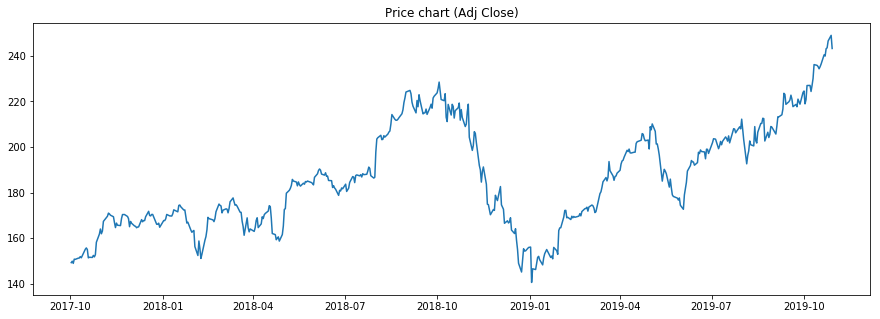

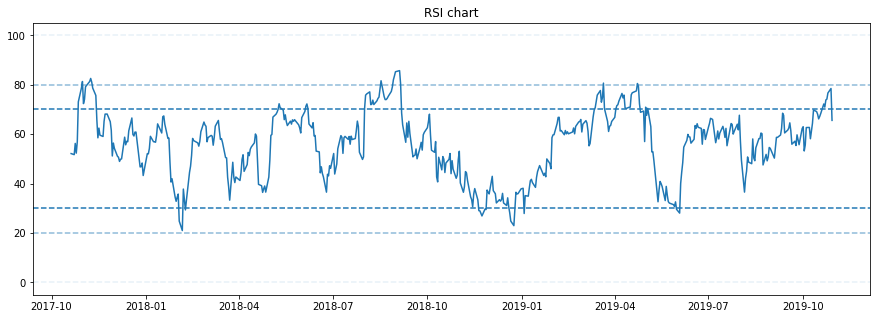

In [103]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close)')
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(df['Date'], df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)
plt.show()

#### Github repository:
git clone https://github.com/tristcoil/RSI-computation-with-Python.git

#### Sources:
- https://www.youtube.com/watch?v=VX6JBxImapM
- http://www.andrewshamlet.net/2017/06/10/python-tutorial-rsi/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

Other:
- https://www.youtube.com/watch?v=y0pil2LbMxU
- https://en.wikipedia.org/wiki/Relative_strength_index
- https://www.investopedia.com/terms/r/rsi.asp